In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression

np.random.seed(42)


In [68]:
data = pd.read_csv(r"/content/data (1).csv")
data.head()

,timestamp,heart_rate,temperature,ax,ay,az,acc_magnitude
0,824664421,80,30.0,0.021729,0.225342,0.949219,0.975842
1,824664451,132,30.0,0.025635,0.227295,0.937744,0.965238
2,824664481,90,30.0,0.021484,0.224854,0.958008,0.984276
3,824664511,95,30.0,0.019531,0.230713,0.954346,0.982031
4,824664002,85,30.0,0.025879,0.208984,0.964844,0.987556


In [69]:
data.columns


Index(['timestamp', 'heart_rate', 'temperature', 'ax', 'ay', 'az',
       'acc_magnitude'],
      dtype='object')

In [70]:
data["timestamp"] = pd.to_datetime(data["timestamp"], unit='s')

data.head()


,timestamp,heart_rate,temperature,ax,ay,az,acc_magnitude
0,1996-02-18 17:27:01,80,30.0,0.021729,0.225342,0.949219,0.975842
1,1996-02-18 17:27:31,132,30.0,0.025635,0.227295,0.937744,0.965238
2,1996-02-18 17:28:01,90,30.0,0.021484,0.224854,0.958008,0.984276
3,1996-02-18 17:28:31,95,30.0,0.019531,0.230713,0.954346,0.982031
4,1996-02-18 17:20:02,85,30.0,0.025879,0.208984,0.964844,0.987556


In [71]:
data = data.sort_values("timestamp")


In [72]:
data = data.set_index("timestamp")
data.index.dtype



dtype('<M8[ns]')

In [73]:
data.reset_index(inplace=True)
data["timestamp"].sort_values().head(20)


,timestamp
0,1970-01-01 00:00:35
1,1970-01-01 00:01:05
2,1970-01-01 00:01:35
3,1970-01-01 00:02:05
4,1996-02-18 17:20:02
5,1996-02-18 17:20:32
6,1996-02-18 17:21:02
7,1996-02-18 17:22:01
8,1996-02-18 17:22:31
9,1996-02-18 17:23:01


In [74]:
data["timestamp"] = data["timestamp"].astype("int64") // 10**9


In [75]:
data = data[data["timestamp"] > 100000000]


In [76]:
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="s")
data = data.sort_values("timestamp")
data = data.set_index("timestamp")
data.index.min(), data.index.max()



(Timestamp('1996-02-18 17:20:02'), Timestamp('1996-02-18 18:17:03'))

In [78]:
np.random.seed(42)

# Normal SpO2 level
data["spo2"] = np.random.normal(97, 1, len(data))

# Slight drop when HR is high
data.loc[data["heart_rate"] > 100, "spo2"] -= np.random.uniform(1, 3)

# Keep within physiological limits
data["spo2"] = data["spo2"].clip(85, 100)

data.head()


,heart_rate,temperature,ax,ay,az,acc_magnitude,spo2
timestamp,,,,,,,
1996-02-18 17:20:02,85,30.0,0.025879,0.208984,0.964844,0.987556,97.496714
1996-02-18 17:20:32,85,30.0,0.021484,0.208740,0.937744,0.960936,96.861736
1996-02-18 17:21:02,85,30.0,0.020752,0.209229,0.959229,0.982001,97.647689
1996-02-18 17:22:01,86,30.0,0.027100,0.203613,0.947021,0.969042,98.523030
1996-02-18 17:22:31,95,30.0,0.017578,0.187988,0.965332,0.983623,96.765847


In [114]:
data["temperature"] = 36.5


In [115]:
features = data.resample("1min").agg({
    "heart_rate": ["mean", "std"],
    "temperature": "mean",
    "spo2": ["mean", "min"],
    "acc_magnitude": ["mean", "std"]
})


features.columns = [
    "avg_hr", "hr_std",
    "avg_temp",
    "avg_spo2", "min_spo2",
    "activity_mean", "activity_std"
]

features.reset_index(inplace=True)

features.head()



,timestamp,avg_hr,hr_std,avg_temp,avg_spo2,min_spo2,activity_mean,activity_std
0,1996-02-18 17:20:00,85.0,0.000000,36.5,97.179225,96.861736,0.974246,0.018823
1,1996-02-18 17:21:00,85.0,NaN,36.5,97.647689,97.647689,0.982001,NaN
2,1996-02-18 17:22:00,90.5,6.363961,36.5,97.644438,96.765847,0.976333,0.010310
3,1996-02-18 17:23:00,117.5,37.476659,36.5,96.354523,95.943183,0.969665,0.013390
4,1996-02-18 17:24:00,84.5,6.363961,36.5,97.148980,96.530526,0.977745,0.006923


In [116]:
features["hr_dev"] = features["avg_hr"] - features["avg_hr"].mean()
features["temp_dev"] = features["avg_temp"] - features["avg_temp"].mean()
features["spo2_dev"] = features["avg_spo2"] - features["avg_spo2"].mean()

features["activity_trend"] = features["activity_mean"].diff().fillna(0)
features["spo2_drop"] = (features["avg_spo2"] < 95).astype(int)
features["monitoring_minute"] = range(1, len(features)+1)



features.ffill(inplace=True)
features.bfill(inplace=True)


In [117]:
len(features)

58

In [118]:
print("Min:", data.index.min())
print("Max:", data.index.max())
print("Total Rows:", len(data))
print("Time Span:", data.index.max() - data.index.min())


Min: 1996-02-18 17:20:02
Max: 1996-02-18 18:17:03
Total Rows: 95
Time Span: 0 days 00:57:01


In [119]:
X = features[[
    "avg_hr", "hr_std",
    "avg_temp",
    "avg_spo2", "min_spo2",
    "activity_mean", "activity_std",
    "hr_dev", "temp_dev", "spo2_dev",
    "activity_trend"
]]

model = IsolationForest(contamination=0.05, random_state=42)
features["anomaly"] = model.fit_predict(X)

features["risk"] = (features["anomaly"] == -1).astype(int)

features.head()


,timestamp,avg_hr,hr_std,avg_temp,avg_spo2,min_spo2,activity_mean,activity_std,hr_dev,temp_dev,spo2_dev,activity_trend,spo2_drop,monitoring_minute,anomaly,risk
0,1996-02-18 17:20:00,85.0,0.000000,36.5,97.179225,96.861736,0.974246,0.018823,-5.193878,0.0,0.330527,0.000000,0,1,1,0
1,1996-02-18 17:21:00,85.0,0.000000,36.5,97.647689,97.647689,0.982001,0.018823,-5.193878,0.0,0.798991,0.007755,0,2,1,0
2,1996-02-18 17:22:00,90.5,6.363961,36.5,97.644438,96.765847,0.976333,0.010310,0.306122,0.0,0.795740,-0.005669,0,3,1,0
3,1996-02-18 17:23:00,117.5,37.476659,36.5,96.354523,95.943183,0.969665,0.013390,27.306122,0.0,-0.494175,-0.006667,0,4,-1,1
4,1996-02-18 17:24:00,84.5,6.363961,36.5,97.148980,96.530526,0.977745,0.006923,-5.693878,0.0,0.300282,0.008080,0,5,1,0


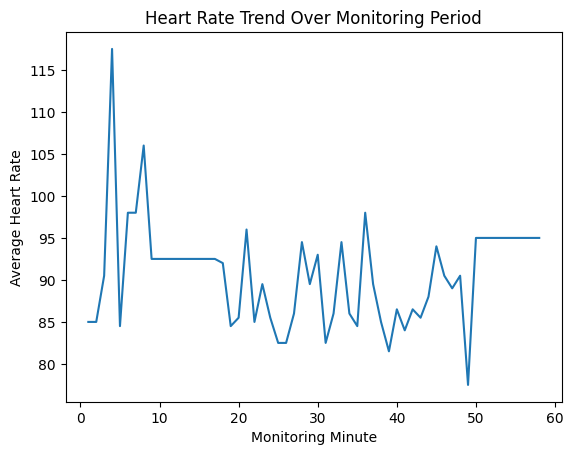

In [120]:
plt.plot(features["monitoring_minute"], features["avg_hr"])
plt.xlabel("Monitoring Minute")
plt.ylabel("Average Heart Rate")
plt.title("Heart Rate Trend Over Monitoring Period")
plt.show()


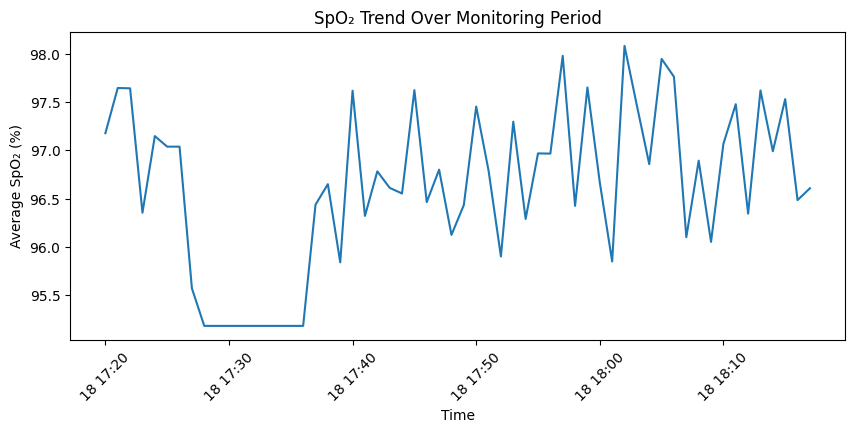

In [121]:
plt.figure(figsize=(10,4))
plt.plot(features["timestamp"], features["avg_spo2"])

plt.title("SpO₂ Trend Over Monitoring Period")
plt.xlabel("Time")
plt.ylabel("Average SpO₂ (%)")
plt.xticks(rotation=45)
plt.show()


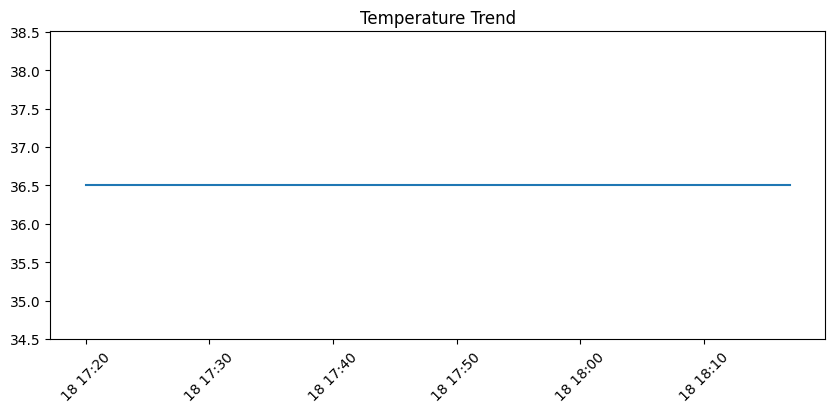

In [122]:
plt.figure(figsize=(10,4))
plt.plot(features["timestamp"], features["avg_temp"])
plt.title("Temperature Trend")
plt.xticks(rotation=45)
plt.show()


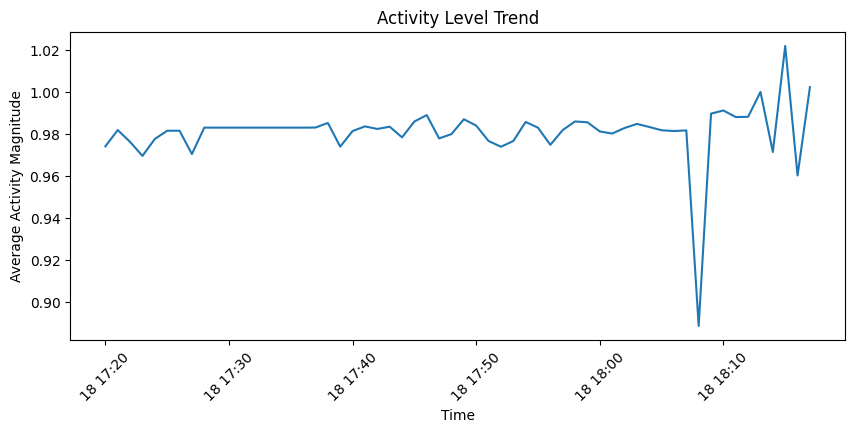

In [123]:
plt.figure(figsize=(10,4))
plt.plot(features["timestamp"], features["activity_mean"])

plt.title("Activity Level Trend")
plt.xlabel("Time")
plt.ylabel("Average Activity Magnitude")
plt.xticks(rotation=45)
plt.show()


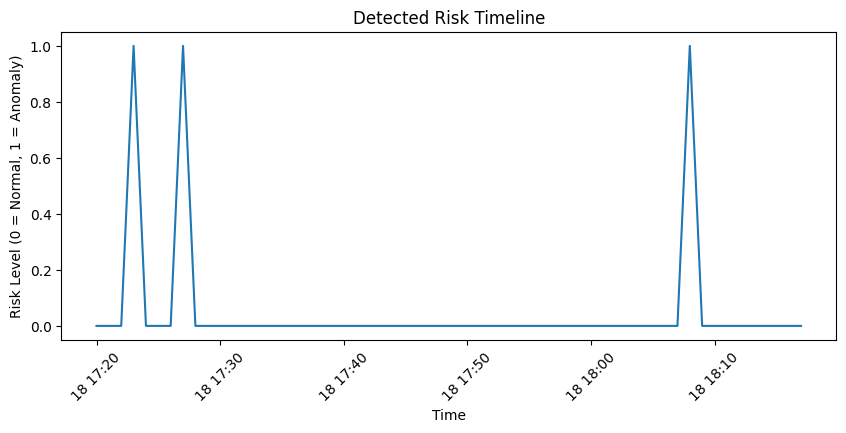

In [124]:
plt.figure(figsize=(10,4))
plt.plot(features["timestamp"], features["risk"])

plt.title("Detected Risk Timeline")
plt.xlabel("Time")
plt.ylabel("Risk Level (0 = Normal, 1 = Anomaly)")
plt.xticks(rotation=45)
plt.show()


In [125]:
features["time_index"] = np.arange(len(features))

reg = LinearRegression()
reg.fit(features[["time_index"]], features["activity_mean"])

features["expected_activity"] = reg.predict(features[["time_index"]])


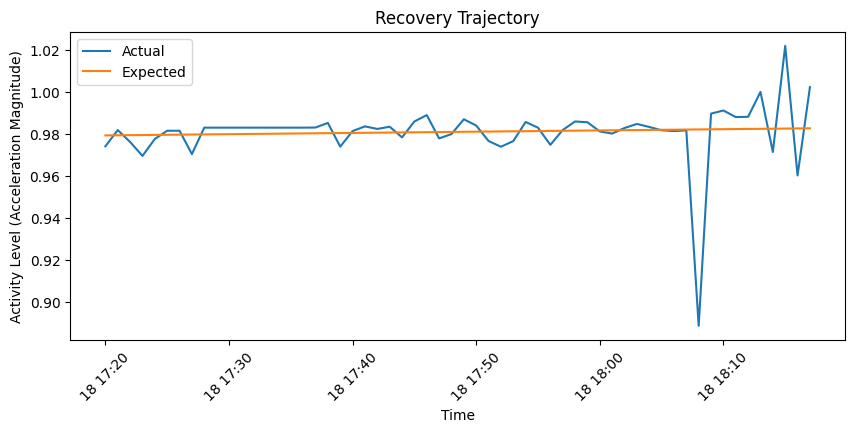

In [126]:
plt.figure(figsize=(10,4))
plt.plot(features["timestamp"], features["activity_mean"], label="Actual")
plt.plot(features["timestamp"], features["expected_activity"], label="Expected")
plt.legend()
plt.title("Recovery Trajectory")

plt.xlabel("Time")
plt.ylabel("Activity Level (Acceleration Magnitude)")
plt.xticks(rotation=45)
plt.show()
